![Vidi_Waterflux_Banner](https://raw.githubusercontent.com/ITC-Water-Resources/Vidi-waterflux-merch/refs/heads/main/jupyter/Vidi_Waterflux_Banner.png)
*Roelof Rietbroek, Sedigheh Karimi, Amin Shakya EGU 2025*

# Create spherical harmonic coefficients for the relevant basins, and compute the associated sea level responses

In [58]:
import os
import geopandas as gpd
import shxarray
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

#local python tools
from common.config import read_config

In [62]:
shxengine='shtns' #requires shtns backend but is much quicker
nmax=300
conf=read_config()
datadir=conf['dataroot']


In [63]:
basinsgpkg=os.path.join(datadir,'hydroshed_csl03_gl_l021.gpkg')

gdfbasins=gpd.read_file(basinsgpkg)

gdfbasins.head()

,PFAF_ID,HYBAS_ID,NEXT_DOWN,NEXT_SINK,MAIN_BAS,DIST_SINK,DIST_MAIN,SUB_AREA,UP_AREA,ENDO,COAST,ORDER,SORT,name,geometry
0,111,1030000010,0,1030000010,1030000010,0.0,0.0,236343.2,236343.2,0,1,0,1,SETIT,"MULTIPOLYGON (((39.76528 15.42917, 39.75492 15..."
1,112,1030003990,0,1030003990,1030003990,0.0,0.0,519027.5,519027.5,0,1,0,2,GULF OF ADEN/SOMALIA,"MULTIPOLYGON (((40.81528 14.75417, 40.79561 14..."
2,114,1030008100,0,1030008100,1030008100,0.0,0.0,797881.4,797881.4,0,0,1,3,SHEBELLE,"MULTIPOLYGON (((36.74167 4.06667, 36.74131 4.0..."
3,117,1030008110,0,1030008110,1030008110,0.0,0.0,1040194.7,1040194.7,0,1,0,4,RUFIJI,"MULTIPOLYGON (((40.84444 -2.43333, 40.83833 -2..."
4,122,1030011660,0,1030011660,1030011660,0.0,0.0,1378103.3,1378121.1,0,0,1,6,ZAMBEZI,"MULTIPOLYGON (((35.2625 -18.23333, 35.26215 -1..."


In [4]:
#Convert to spherical harmonics
dbasins_sh=xr.DataArray.sh.from_geoseries(gdfbasins.geometry,nmax,auxcoord=gdfbasins.name,engine=shxengine)
dbasins_sh.name='basins'
display(dbasins_sh)



[SHTns 3.7.3] built Mar 13 2025, 15:36:25, id: v3.7-9-gbfb51b8*,avx2,ishioka,openmp,cuda


shxarray-INFO: Masking and gridding polygons
shxarray-INFO: Applying SH analysis


<xarray.DataArray 'basins' (name: 124, nm: 90601)> Size: 90MB
array([[ 4.67155721e-04,  4.50576181e-04,  2.79101075e-04, ...,
        -1.22487597e-08,  5.34087354e-09,  1.67106718e-09],
       [ 9.95285262e-04,  1.24095001e-03,  2.54781007e-04, ...,
         6.88946979e-06, -1.53689235e-05, -1.89362638e-05],
       [ 1.55033108e-03,  1.76372889e-03,  1.93507773e-04, ...,
        -2.19382474e-06,  6.74174186e-05,  1.33737188e-05],
       ...,
       [ 4.53385911e-03,  5.27524861e-03,  5.40705165e-03, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.80618953e-03,  3.40975763e-03,  3.35741112e-03, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.17184848e-03,  1.69395257e-03,  1.10839981e-03, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],
      shape=(124, 90601))
Coordinates:
  * nm       (nm) object 725kB MultiIndex
  * n        (nm) int64 725kB 0 1 1 1 2 2 2 2 ... 300 300 300 300 300 300 300
  * m        (nm) int64 725kB 0 -1 0 1 -2 -1 0 1 ... 294 295 296 297 298 299 300
  * name     (name) object 992B 'SETIT' ... 'TIBETAN PLATEAU'
Attributes:
    Conventions:  CF-1.8
    source:       shxarray-1.3.1.dev0+gc9b9093.d20250313 <https://github.com/...
    contact:      Roelof Rietbroek <r.rietbroek@utwente.nl>
    institution:  ITC Faculty of Geo-Information Science and Earth Observatio...
    comments:     Used backend: SHTns High performance Spherical Harmonic Tra...
    history:      Analysis operation

Text(0.5, 1.0, 'SHEBELLE')

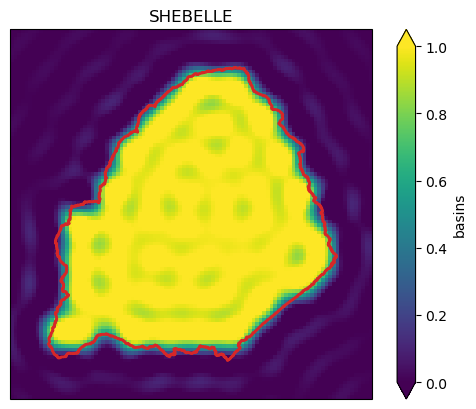

In [57]:
#quick visual check

basin='SHEBELLE'
gdfbasin=gdfbasins.loc[gdfbasins.name==basin]
lonmin,latmin,lonmax,latmax=gdfbasin.geometry.bounds.iloc[0]
res=0.125
margin=10*res
dbasin_grd=dbasins_sh.sel(name=basin).sh.synthesis(lon=np.arange(lonmin-margin,lonmax+margin,res),lat=np.arange(latmin-margin,latmax+margin,res))
ax = plt.axes(projection=ccrs.PlateCarree())
dbasin_grd.plot(ax=ax,vmax=1,vmin=0,transform=ccrs.PlateCarree())
ax.add_geometries(gdfbasin.geometry,edgecolor='tab:red',crs=ccrs.PlateCarree(),facecolor="none",lw=2)
ax.set_title(basin)

In [64]:
#save to netcdf for re-use
basinsshout=os.path.join(datadir,conf['ncbasin'])
dbasins_sh.reset_index('nm').to_netcdf(basinsshout)